# DSCI 100 006 Group 32 Project Report
## Exploring the Factors Affecting Housing Prices in Taiwan: A K Nearest Neighbour Regression Analysis of House Age, Location, Proximity to MRT Stations, and Convenience Store Density 
Jim Geng, Madalyn Stekl, William Kawira, Shikha Rajesh  

## Introduction

Real estate valuation is the process of determining a property's economic value. It is very important for the real estate market to determine how much houses are worth, so sellers can determine the price they should list their house for, and buyers can make sure that they are not being overcharged, and make a reasonable offer on a house. Supply and demand are big drivers of the real estate market, but other variables such as age, condition, terms and conditions of sale, location, lot size, and distance to amenities are also taken into account when a property is evaluated. 

The goal of our project is to establish the relationships between the price of the house and other variables such as house age, the distance to the nearest MRT station, and the number of convenience stores within a walkable distance. We will perform a regression analysis to determine the strength of these relationships.

Our dataset is a historical record of real estate evaluation in the Sindian District of New Taipei City, Taiwan. The dataset is comprised of the observation number, the date that the house was evaluated, the age of the house in years, the distance to the nearest Mass Rapid Transit (MRT) station in meters, the number of convenience stores in walking distance, the latitude and longitude in degrees, and finally the house price per unit area (10000 New Taiwan Dollar per Ping ~ 3.3m²). There are 414 observations in the dataset, taken between August of 2012 and July of 2013. 

## Data Analysis Methods and Results
#### Preliminary Data Cleaning and Wrangling

To start off, we added the necessary library packages to perform our analysis.

In [3]:
set.seed(2023)
# Importing libraries

library(readxl)
library(repr)
library(readr)
library(ggplot2)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

To obtain the data, we downloaded a excel spreadsheet from University of California Irvine's data science machine learning host server and imported it into R through the `read_xlsx()` function.

In [4]:
# File download
house_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
dest_file <- "Real estate valuation data set.xlsx"
download.file(house_url, dest_file)

# Read file
house_data <- read_xlsx("Real estate valuation data set.xlsx")
house_data

No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012.917,32.0,84.87882,10,24.98298,121.5402,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.5395,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.5439,47.3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
412,2013.25,18.8,390.96960,7,24.97923,121.5399,40.6
413,2013.00,8.1,104.81010,5,24.96674,121.5407,52.5
414,2013.50,6.5,90.45606,9,24.97433,121.5431,63.9


*Table 1. Initial Taiwanese housing data downloaded from University of California dataset website.*

Next, the data was wrangled, cleaned, and the predictors for the knn regression were selected. To do this, we removed extraneous columns, selected the relevant columns for our analysis, and renamed them. 

In [5]:
# Cleaning column names and removing extraneous columns.
house_data <- house_data |> 
    rename(
        age = "X2 house age",
        station_distance = "X3 distance to the nearest MRT station",
        store_count = "X4 number of convenience stores",
        price_per_unit = "Y house price of unit area"
    ) |>
    select(-c("No", "X1 transaction date", "X5 latitude", "X6 longitude")) |>
    mutate(store_count = store_count)
house_data

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
32.0,84.87882,10,37.9
19.5,306.59470,9,42.2
13.3,561.98450,5,47.3
⋮,⋮,⋮,⋮
18.8,390.96960,7,40.6
8.1,104.81010,5,52.5
6.5,90.45606,9,63.9


*Table 2. Cleaned and wrangled version of the Taiwanese housing data, with unused columns removed and column names renamed for analysis.*

To prepare the data for analysis, we split the data into a training and testing set with 75%  of the data as training and 25% of the data as testing. 

In [6]:
set.seed(2023)
# Splitting data into training and testing sets.
house_split <- initial_split(house_data, prop = 0.75, strata = price_per_unit)
house_train <- training(house_split)
house_test <- testing(house_split)

Next, we produced some summary statistics of our data: the mean of all of our variables.

In [7]:
# Summary statistics
house_train_mean <- house_train |>
    summarize(across(age:price_per_unit, mean))
house_train_mean

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
17.55032,1059.566,4.159091,38.20779


*Table 3. Summary table describing the mean value of each column.*

Our data does not have any missing values, nor does it have any discrepancies in the amount of observations in each class, so here we have printed out the mean of each predictor variable. Paired with visualizations and values from the original dataset, this allows for easier identification of potential outlier values when compared with these mean values.

#### Preliminary Data Exploration

We then produced some exploratory visualizations of our data: scatterplots of house price vs. age, house price vs. distance to the nearest mass rapid transit station, and house price vs. the number of nearby convenience stores. These established some general hints as to whether or not there are strong enough relationships between the variables to use them for our regression analysis.


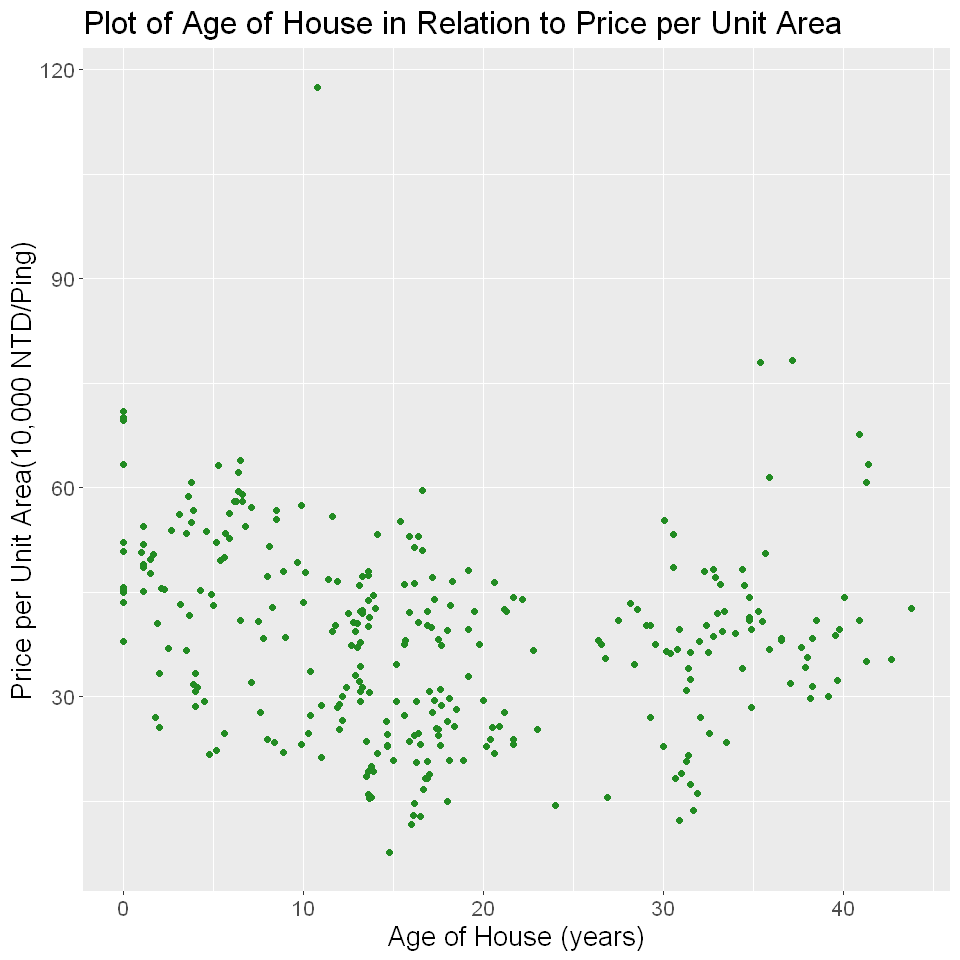

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)

# Age vs price scatterplot
age_price_plot <- house_train |> 
    ggplot(aes(x = age, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Age of House (years)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 16)) + 
    ggtitle("Plot of Age of House in Relation to Price per Unit Area")
age_price_plot

*Figure 1. Plot of the relationship between the age of the residence and its price per unit area.*

This scatterplot shows that the age of house and price may not have a strong correlation. The data has a slightly negative correlation at first that flattens out as the age of house increases. There are also outlier data points with four houses at the 35-40 years old range.

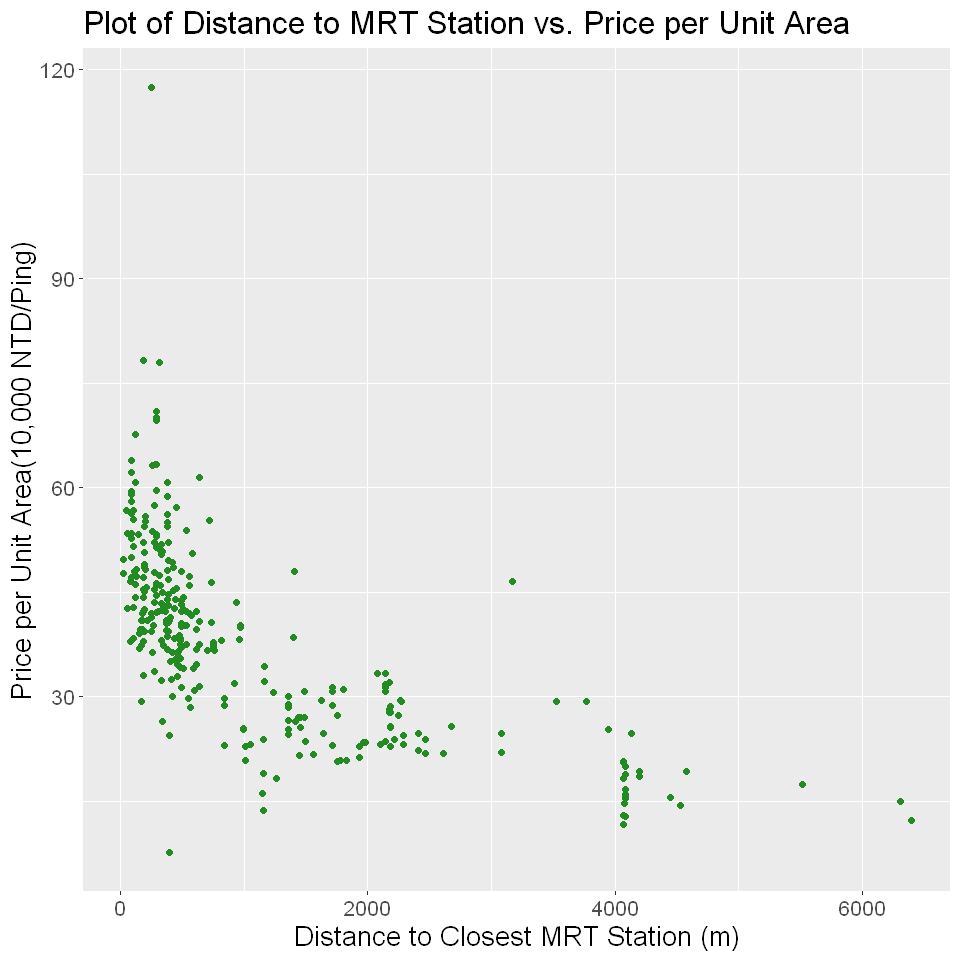

In [9]:
# Distance to station vs price scatterplot
station_price_plot <- house_train |> 
    ggplot(aes(x = station_distance, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Distance to Closest MRT Station (m)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    ggtitle("Plot of Distance to MRT Station vs. Price per Unit Area") +
    theme(text = element_text(size = 16))
station_price_plot

*Figure 2. Plot of the relationship between the house's distance to the closest public transit station and its price per unit area.*

There is noticable negative correlation between the distance to closest MRT (public transportation) station, and KNN regression has the potential to be useful here since the correlation does not seem to be completely linear. 

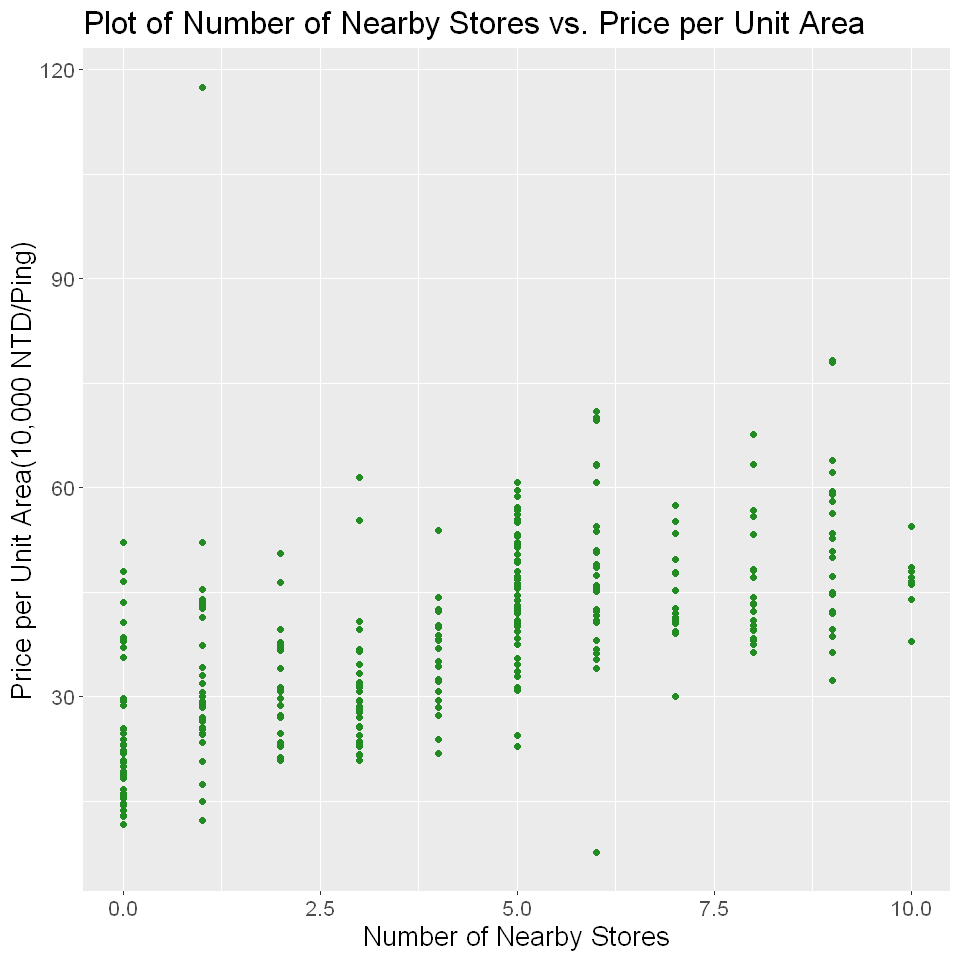

In [10]:
# Number of nearby stores vs price scatterplot
store_price_plot <- house_train |> 
    ggplot(aes(x = store_count, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Number of Nearby Stores", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Plot of Number of Nearby Stores vs. Price per Unit Area")
store_price_plot

*Figure 3. Plot of the relationship between the number of nearby convenience stores of the house and its price per unit area.*

This figure shows a moderately strong postive correlation between the number of nearby stores and the price of housing. The correlation seems to be fairly linear. This indicates that a linear regression model could be an alternative approach in the future if another different regression model is completed with only number of nearby stores used as a singular predictor. However, for the sake of doing a multivariable regression we will apply KNN regression with all of the predictors since KNN fits the other predictors more.

#### K Nearest Neighbour Regression 
#### Tuning
The first step in our regression analysis was to preform a 5-fold cross-validation to choose the best k value for our analysis. To do this, we first split our data into 5 sections. We then decided that we would test k values of 1-100 through using a tibble of these values, so we could tune our workflow to test for the best K value. 

In [11]:
set.seed(2023)
# V-Fold Function
house_vfold <- vfold_cv(house_train, v = 5, strata = price_per_unit)

# Number of K Neighbours to test
gridvals <- tibble(neighbors = seq(1,100))

The nest step of our regression was to create a K-Nearest Neighbours specification for our tuning step.

In [12]:
# KNN Model
house_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

 A recipe for house price prediction in relation to the three predictors is created, and the recipe and model specification is combined together in a workflow to output a optimal K value.

In [13]:
# Regression recipe
house_recipe <- recipe(price_per_unit ~ ., data = house_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Tuning step
house_tune_results <- workflow() |> 
    add_recipe(house_recipe) |> 
    add_model(house_spec) |> 
    tune_grid(resamples = house_vfold, grid = gridvals) |> 
    collect_metrics()

# Tuning result table, uncomment to view
# house_tune_results

# Finding minimum rmse
house_tune_min <- house_tune_results |> 
    filter(.metric == "rmse") |> 
    arrange(mean) |> 
    head(4)

house_tune_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,rmse,standard,9.172155,5,0.9662820,Preprocessor1_Model015
16,rmse,standard,9.175129,5,0.9780684,Preprocessor1_Model016
12,rmse,standard,9.176345,5,0.9654732,Preprocessor1_Model012
14,rmse,standard,9.176514,5,0.9630439,Preprocessor1_Model014


*Table 4. V-fold cross validation results showcasing the first four K values with the lowest RMSE values.*

Here, with 5-fold cross validation done with k = 1 to 100, it is revealed that k = 15 gave the minimum rmse value. This can be further supported by the following line plot.

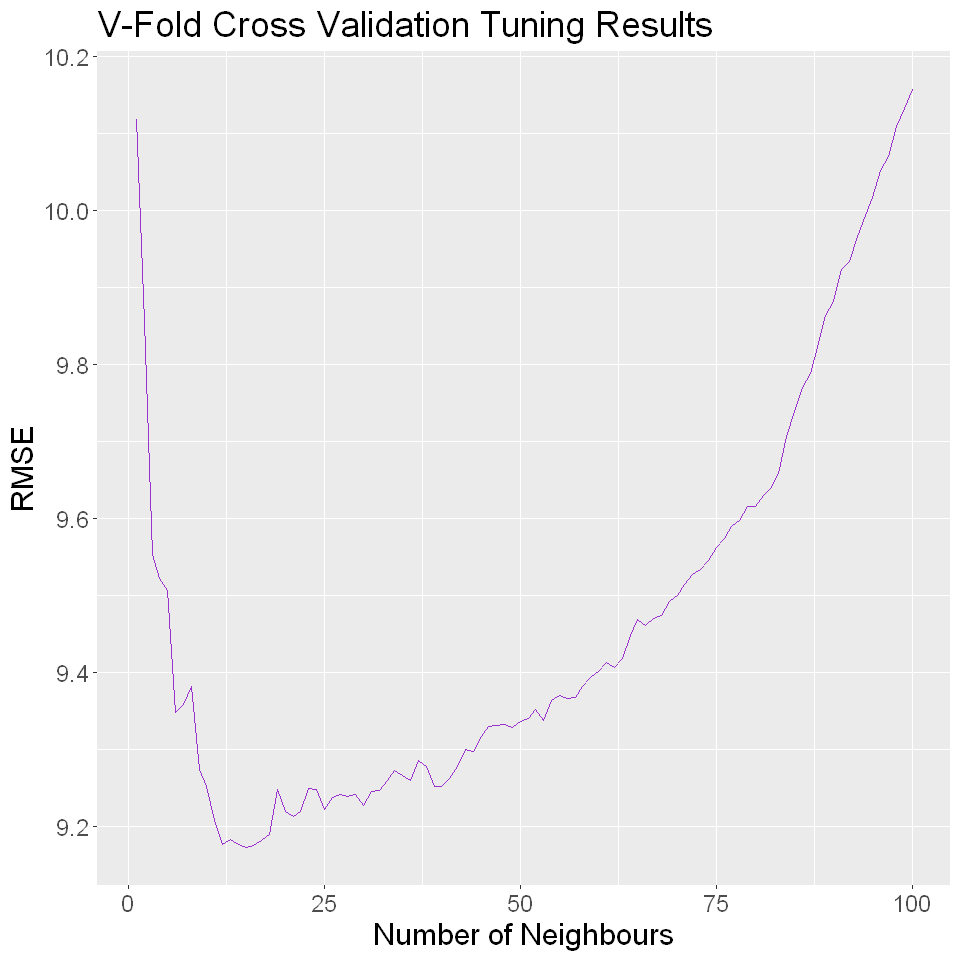

In [14]:
#Plotting the cross validation plot to show k=15
house_tune_plot <- house_tune_results |> 
    filter(.metric == "rmse") |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_line(col = "darkorchid3") +
        xlab("Number of Neighbours") +
        ylab("RMSE") +
        ggtitle("V-Fold Cross Validation Tuning Results") +
        theme(text = element_text(size = 18))
#Printing the plot
house_tune_plot

*Figure 4. V-fold cross validation results showing the minimum rmse value tuned by testing K values from 1 to 100.* 

With the optimal k-value, the multivariable KNN regression can now be performed.

#### Model Fitting

We then were finally able to make predictions on our test data, and computed a summary of the quality of our regression, which gives us the final RMSPE of our model.

In [15]:
set.seed(2023)

# Extracting best K value
k_min <- house_tune_min |> 
    head(1) |>
    pull(neighbors)

# Creating a new model based on the best K value
house_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |> 
    set_engine("kknn") |> 
    set_mode("regression")

# New model with the optimal K value
house_best_fit_results <- workflow() |> 
    add_recipe(house_recipe) |> 
    add_model(house_best_spec) |> 
    fit(data = house_train)

# Predicting variables in house_test
house_preds <- house_best_fit_results |> 
    predict(house_test) |>
    bind_cols(house_test)

# Building the summary table showing the overall RMSPE value of our KNN regression
house_summary <- house_preds |>
    metrics(truth = price_per_unit, estimate = .pred)

# Printing the summary table
house_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,7.8311030
rsq,standard,0.6271196
mae,standard,5.8044025


*Table 5. Summary table showing that the overall RMSPE value of our KNN regression model is around 7.831 price per unit area.*

#### Model Visualization
Finally, we visualized our predictions by plotting the price versus each of our predictor variables with the prediction line overlaid on the scatterplot of the testing data. This allows us to see how accurate our prediction was for each of the separate variables.

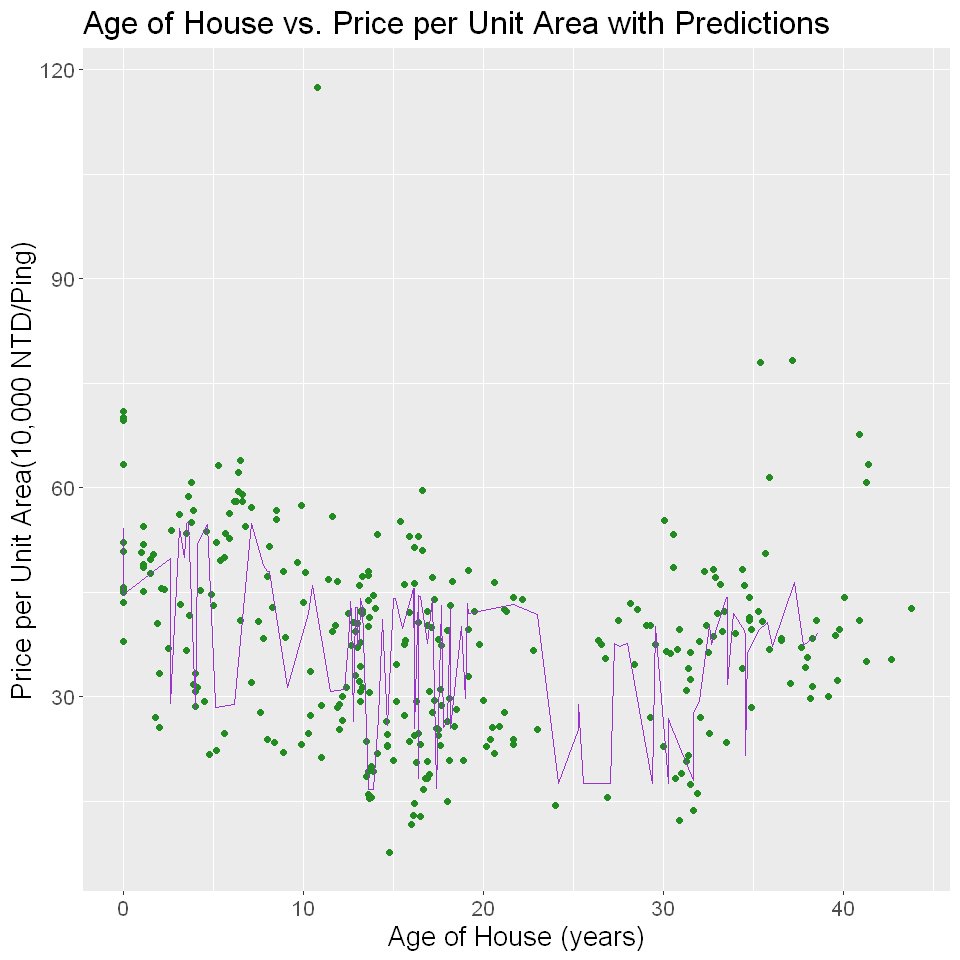

In [16]:
# Plotting the relationship between the house's age and its price per unit area of the testing data, 
# overlaid with KNN prediction line
age_price_plot <- house_train |> 
    ggplot(aes(x = age, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    geom_line(
        data = house_preds,
        mapping = aes(x = age, y = .pred),
        color = "darkorchid3") +
    labs(x = "Age of House (years)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 16)) + 
    ggtitle("Age of House vs. Price per Unit Area with Predictions")

# Printing the plot
age_price_plot

*Figure 5. Plot of the relationship between the house's age and its price per unit area of the testing data, overlaid with KNN prediction line*

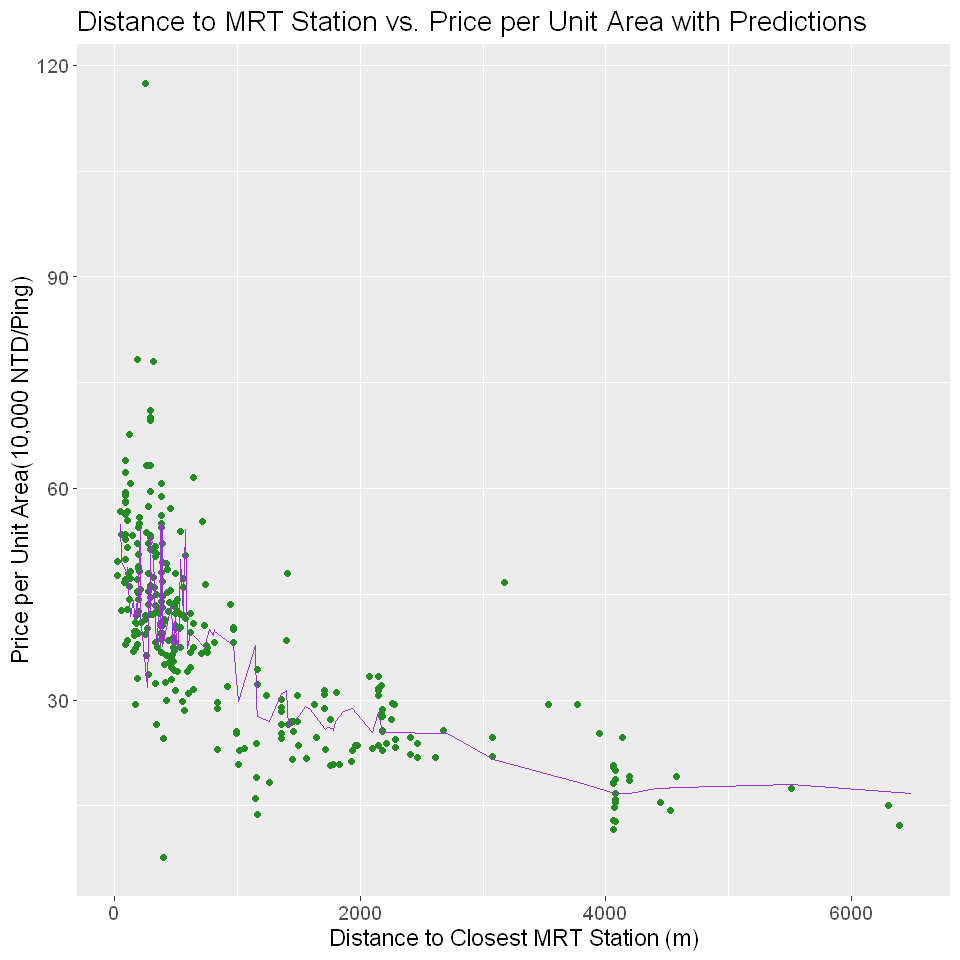

In [17]:
# Plotting of the relationship between the house's distance to the closest public transit station 
# and its price per unit area of the testing data, overlaid with KNN prediction line  
station_price_plot <- house_train |> 
    ggplot(aes(x = station_distance, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    geom_line(
        data = house_preds,
        mapping = aes(x = station_distance, y = .pred),
        color = "darkorchid3") +
    labs(x = "Distance to Closest MRT Station (m)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    ggtitle("Distance to MRT Station vs. Price per Unit Area with Predictions") +
    theme(text = element_text(size = 14))

# Printing the plot
station_price_plot

*Figure 6. Plot of the relationship between the house's distance to the closest public transit station and its price per unit area of the testing data, overlaid with KNN prediction line*

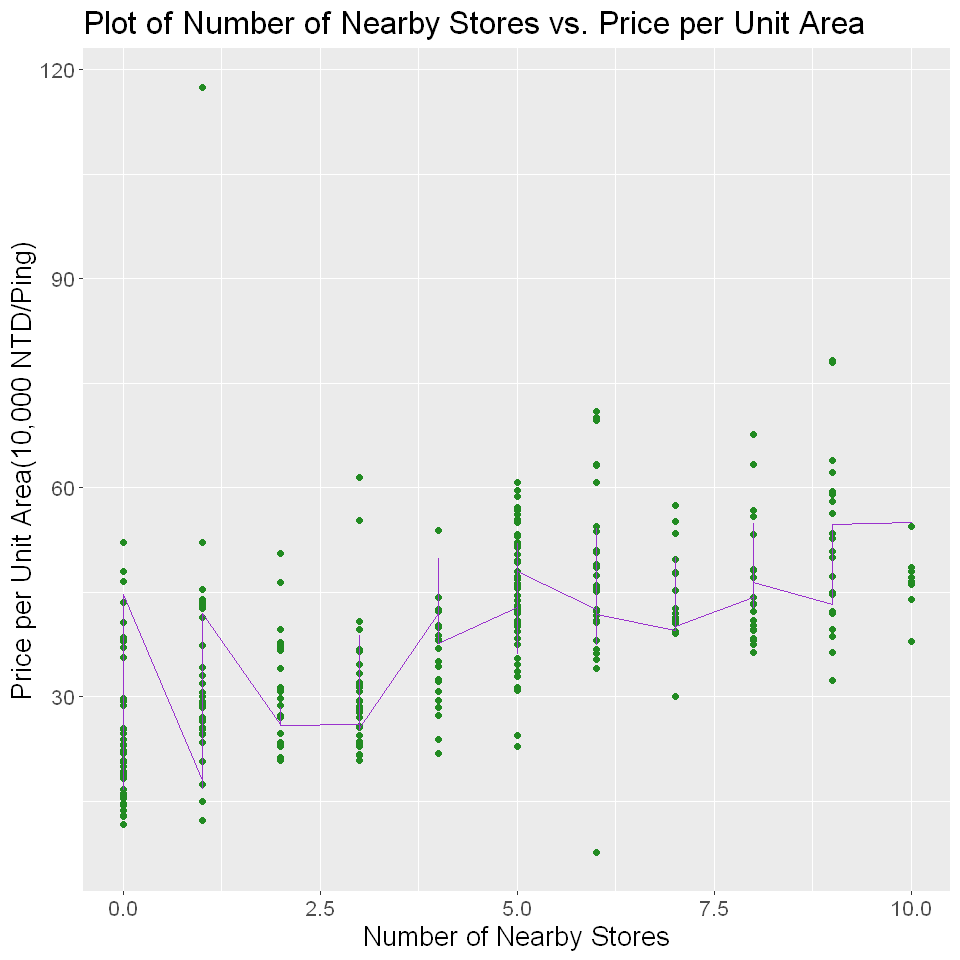

In [18]:
# Plotting of the relationship between the density of nearby convenience stores and the house's price 
# per unit area of the testing data, overlaid with KNN prediction line  
store_price_plot <- house_train |> 
    ggplot(aes(x = store_count, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    geom_line(
        data = house_preds,
        mapping = aes(x = store_count, y = .pred),
        color = "darkorchid3") +
    labs(x = "Number of Nearby Stores", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Plot of Number of Nearby Stores vs. Price per Unit Area")

# Printing the plot
store_price_plot

*Figure 7. Plot of the relationship between the density of nearby convenience stores and the house's price per unit area of the testing data, overlaid with KNN prediction line*

## Discussion

In our analysis, we found that the relationships between some of our variables and house prices were weak at best, while other variables were found to have some correlation and relationship. As we saw in our exploratory graphs, there was no clear relationship between house age and price. The points are scattered, with the prediction line fluctuating throughout the point cloud. The prediction line does follow the areas with the highest density of points, thus it can be assumed that the model did produce an adequate regression for house price based on age, given the circumstances. The visualization for price based on the distance to rapid transit stations displays a clear negative relationship between these variables. As the distance from a station increases, the house price decreases. The K-nearest neighbours regression line optimally demonstrates this negative non-linear relationship. For our last variable, the number of convenience stores within a walkable distance, a weak positive relationship can be found. As the store density around the house increases, the price of the house does as well. The overall trend of the prediction line does showcase this relationship. However, the staggered nature of the trendline reinforces our idea in the preliminary data analysis that a linear regression approach towards the store density variable may be a better approach towards giving better predictions.

When analyzing the error of our regression, we found that the error decreased when testing our final model.  During the k-value tuning process, the lowest RMSE had an error of 9.17. When testing our final model, the RMSPE went down to 7.83. This translates to an error of around 78,000 New Taiwan Dollars per Ping, or $1,000 CAD per m².             


Our initial proposal predictions was the existence of some relationship between house age, distance to the nearest MRT station, and density of nearby convenience stores with the house price. We expected there to be a negative relationship between house price and age, as houses lose value as they become older. We also expected there to be a negative relationship between distance to MRT station and house price, as houses typically have a higher value closer to transit stations. Finally, we expected a positive correlation between number of nearby convenience stores and house price, as the increased store count accounts for easier access to quick goods and services. As discussed above, we did not find much of a relationship between house age and price. However, the data did confirm our expectations of a negative relationship between distance to transit station and house price, as well as a positive (but jagged) relationship between density of nearby stores and house price.

The relationships between house age, distance to the nearest MRT station, density of nearby convenience stores and house price could impact various stakeholders in the New Taipei City real estate market. Homebuyers and sellers may use this information to negotiate prices, while real estate developers and investors may consider these factors in their investment decisions and development strategies. Urban planners and policymakers could incorporate these findings into land-use planning and housing policies. Financial institutions and appraisers may also take these findings into account when assessing property values. Overall, these findings could provide valuable insights for decision-makers in the real estate industry or influence pricing strategies, investment decisions, and policy considerations related to housing markets.


In the future, we can explore how other factors such as proximity to public transportation, amenities, schools, demographics, crime rates, environmental factors, housing supply, economic conditions, and cultural influences would impact house prices. Research could involve empirical studies, statistical analyses, and interdisciplinary approaches to understand the complex dynamics that shape the housing market and inform decision-making. The findings could provide further insights for homeowners, policymakers, and real estate professionals to better understand and manage the relationship between these factors and house prices in the future.

## References

Cheng, K. M. (2018). The factors and implications of rising housing prices in Taiwan. Brookings Institution. https://www.brookings.edu/opinions/the-factors-and-implications-of-rising-housing-prices-in-taiwan/

Chiang, Y., Peng, T., & Chang, C. (2015). The nonlinear effect of convenience stores on residential property prices: A case study of Taipei, Taiwan. Habitat International(46) 82–90. 
https://doi.org/10.1016/j.habitatint.2014.10.017

Yeh, I. C., & Hsu, T. K. (2018). Real estate valuation data set [Data set]. Tamkang University. https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set
